# Recommender Systems with Python

This notebook focuses on providing a basic recommendation system by suggesting items that are most similar to a particular item, in this case, movies. Keep in mind, this is not a true robust recommendation system, to describe it more accurately,it just tells you what movies/items are most similar to your movie choice.

Let's get started!

## Import Libraries

In [441]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style # for styling the graphs
# style.available (to know the available list of styles)
style.use('fivethirtyeight') # chosen style
#[f.name for f in matplotlib.font_manager.fontManager.afmlist] (to know the available list of fonts)
matplotlib.rcParams['font.family'] = "serif"
plt.rc('xtick',labelsize=13) # to globally set the tick size
plt.rc('ytick',labelsize=13) # to globally set the tick size
import seaborn as sns

# To print multiple outputs together
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Change column display number during print
pd.set_option('display.max_columns', 500)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# To display float with 2 decimal, avoid scientific printing
pd.options.display.float_format = '{:.2f}'.format

## Get and prepare the Data

In [442]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
movie_titles = pd.read_csv("Movie_Id_Titles")
df = pd.read_csv('u.data', sep='\t', names=column_names)
df.head()
movie_titles.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


We can merge them together:

In [443]:
df = pd.merge(df,movie_titles,on='item_id')
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


Some values are **'unknown'** in the **title** column, let's drop them and also extract **Year** from title column.

In [444]:
# removing unknown titles
df[df['title'] == 'unknown']
df.drop(df[df['title']=='unknown'].index, inplace=True)

# Extracting year
df['year'] = df['title'].str.extract('(\(\d+\))')[0].str.strip('()')
df['year'] = df['year'].astype('int')

,user_id,item_id,rating,timestamp,title
84859,130,267,5,875801239,unknown
84860,5,267,4,875635064,unknown
84861,268,267,3,875742077,unknown
84862,297,267,3,875409139,unknown
84863,319,267,4,875707690,unknown
84864,1,267,4,875692955,unknown
84865,532,267,3,875441348,unknown
84866,833,267,1,875655669,unknown
84867,422,267,4,875655986,unknown


# EDA

Let's explore the data a bit and get a look at some of the best rated movies.

## Visualization Imports

### Let's create a ratings dataframe with average rating and number of ratings:

In [445]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())

ratings.reset_index(inplace=True)
ratings['year'] = ratings['title'].str.extract('(\(\d+\))')[0].str.strip('()')
ratings['year'] = ratings['year'].astype('int')
ratings.set_index('title', inplace=True)

ratings.head()

,rating,num of ratings,year
title,,,
'Til There Was You (1997),2.33,9,1997
1-900 (1994),2.60,5,1994
101 Dalmatians (1996),2.91,109,1996
12 Angry Men (1957),4.34,125,1957
187 (1997),3.02,41,1997


### Top 5 movies with the highest number of ratings.

In [446]:
ratings.sort_values(by=['num of ratings'], ascending=False).head()

,rating,num of ratings,year
title,,,
Star Wars (1977),4.36,584,1977
Contact (1997),3.80,509,1997
Fargo (1996),4.16,508,1996
Return of the Jedi (1983),4.01,507,1983
Liar Liar (1997),3.16,485,1997


#### Now a few histograms:

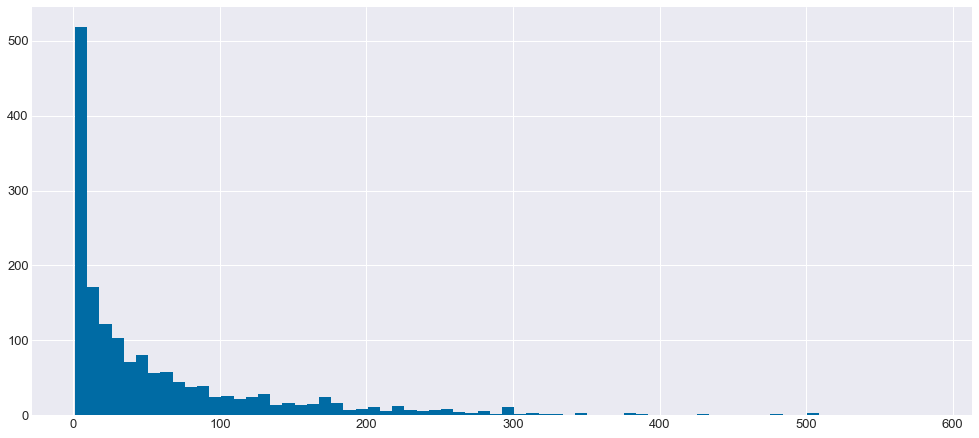

In [412]:
plt.figure(figsize=(15,7));
ratings['num of ratings'].hist(bins=70);

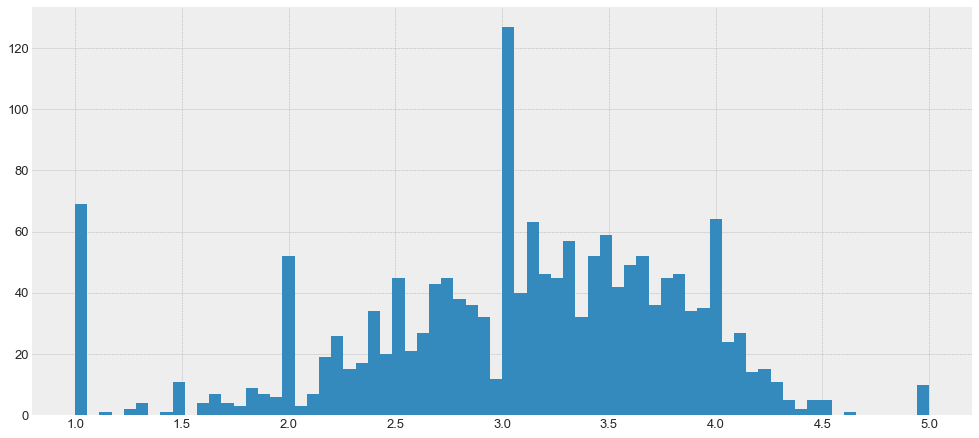

In [414]:
plt.figure(figsize=(15,7));
ratings['rating'].hist(bins=70);

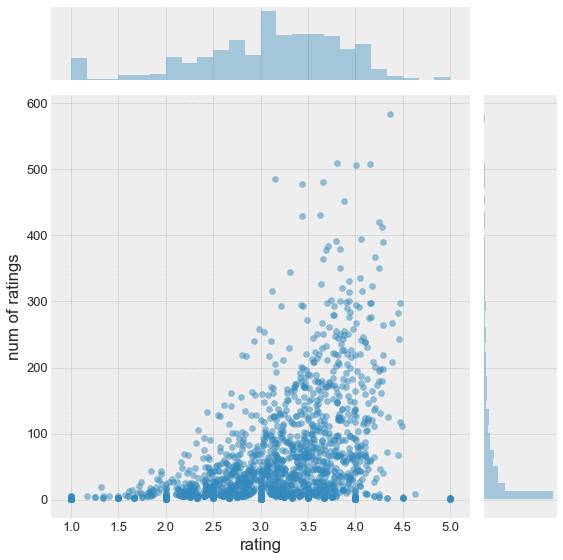

In [415]:
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.5, height=8);

- There is an exponential relationship between **user rating** and **number of ratings**.

### Which year has the maximum number of movie releases ?

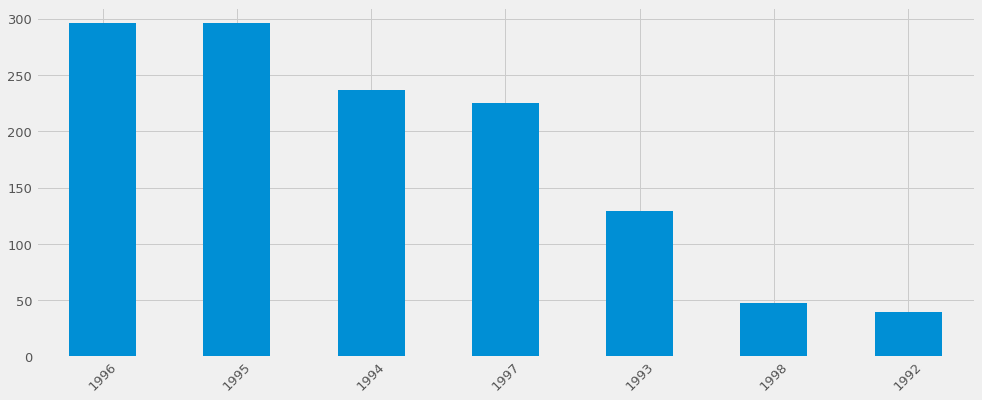

In [404]:
ratings['year'].value_counts().head(7).plot(kind='bar', figsize=(15,6));
plt.xticks(rotation=45);

Similar number of movies were released in the year **1995** and **1996**.

### Which year has the highest average rating given by users ?

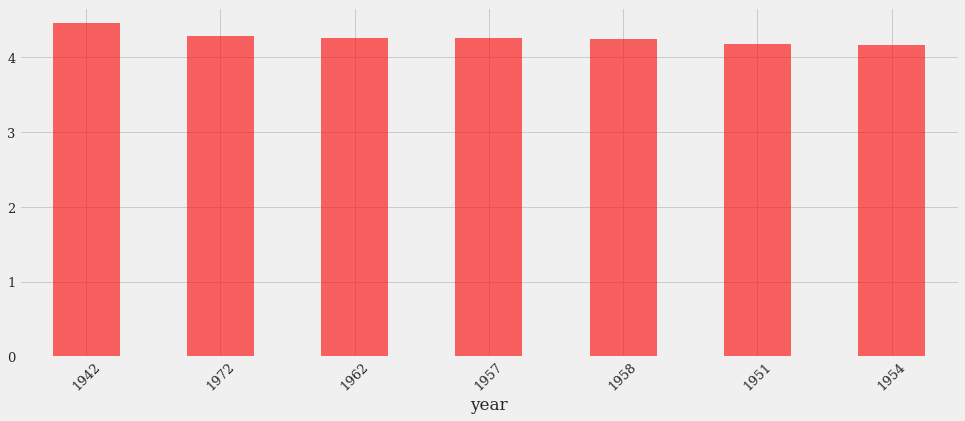

In [440]:
ratings[ratings['num of ratings'] > 100].groupby('year')['rating'].mean().sort_values(ascending=False).head(7).plot(kind='bar', figsize=(15,6), colormap='rainbow_r', alpha=0.6);
plt.xticks(rotation=45);

Even though majority of movies were released in the 1990's most of the movies released during other years have higher average ratings.

**Okay! Now that we have a general idea of what the data looks like, let's move on to creating a simple recommendation system:**

## Recommending Similar Movies

In [210]:
moviemat = df.pivot_table(index='user_id',columns='title',values='rating')
moviemat.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",8 1/2 (1963),8 Heads in a Duffel Bag (1997),8 Seconds (1994),A Chef in Love (1996),Above the Rim (1994),Absolute Power (1997),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Across the Sea of Time (1995),Addams Family Values (1993),Addicted to Love (1997),"Addiction, The (1995)","Adventures of Pinocchio, The (1996)","Adventures of Priscilla, Queen of the Desert, The (1994)","Adventures of Robin Hood, The (1938)","Affair to Remember, An (1957)","African Queen, The (1951)",Afterglow (1997),"Age of Innocence, The (1993)",Aiqing wansui (1994),Air Bud (1997),Air Force One (1997),"Air Up There, The (1994)",Airheads (1994),Akira (1988),Aladdin (1992),Aladdin and the King of Thieves (1996),Alaska (1996),Albino Alligator (1996),Alice in Wonderland (1951),Alien (1979),Alien 3 (1992),Alien: Resurrection (1997),Aliens (1986),All About Eve (1950),All Dogs Go to Heaven 2 (1996),All Over Me (1997),All Things Fair (1996),Alphaville (1965),Amadeus (1984),Amateur (1994),"Amazing Panda Adventure, The (1995)",American Buffalo (1996),American Dream (1990),"American President, The (1995)",American Strays (1996),"American Werewolf in London, An (1981)","American in Paris, An (1951)",Amistad (1997),Amityville 1992: It's About Time (1992),Amityville 3-D (1983),"Amityville Curse, The (1990)","Amityville Horror, The (1979)",Amityville II: The Possession (1982),Amityville: A New Generation (1993),Amityville: Dollhouse (1996),Amos & Andrew (1993),An Unforgettable Summer (1994),Anaconda (1997),Anastasia (1997),Andre (1994),Angel Baby (1995),Angel and the Badman (1947),Angel on My Shoulder (1946),Angela (1995),Angels and Insects (1995),Angels in the Outfield (1994),Angus (1995),Anna (1996),Anna Karenina (1997),Anne Frank Remembered (1995),Annie Hall (1977),Another Stakeout (1993),Antonia's Line (1995),Aparajito (1956),"Apartment, The (1960)",Apocalypse Now (1979),Apollo 13 (1995),"Apostle, The (1997)","Apple Dumpling Gang, The (1975)",April Fool's Day (1986),Apt Pupil (1998),"Aristocats, The (1970)",Army of Darkness (1993),Around the World in 80 Days (1956),"Arrival, The (1996)",Arsenic and Old Lace (1944),As Good As It Gets (1997),Assassins (1995),"Assignment, The (1997)","Associate, The (1996)",Audrey Rose (1977),August (1996),Austin Powers: International Man of Mystery (1997),"Awfully Big Adventure, An (1995)",Ayn Rand: A Sense of Life (1997),B*A*P*S (1997),B. Monkey (1998),Babe (1995),"Baby-Sitters Club, The (1995)",Babyfever (1994),"Babysitter, The (1995)",Back to the Future (1985),Backbeat (1993),Bad Boys (1995),Bad Company (1995),Bad Girls (1994),Bad Moon (1996),Bad Taste (1987),"Ballad of Narayama, The (Narayama Bushiko) (1958)",Balto (1995),Bananas (1971),"Band Wagon, The (1953)",Barb Wire (1996),Barbarella (1968),Barcelona (1994),Basic Instinct (1992),"Basketball Diaries, The (1995)",Basquiat (1996),Bastard Out of Carolina (1996),Batman & Robin (1997),Batman (1989),Batman Forever (1995),Batman Returns (1992),Baton Rouge (1988),Bean (1997),"Beans of Egypt, Maine, The (1994)",Beat the Devil (1954),"Beautician and the Beast, The (1997)",Beautiful Girls (1996),Beautiful Thing (1996),Beauty and the Beast (1991),Beavis and Butt-head Do America (1996),Bed of Roses (1996),Bedknobs and Broomsticks (1971),Before Sunrise (1995),Before and After (1996),Before the Rain (Pred dozhdot) (1994),Being Human (1993),Being There (1979),"Believers, The (1987)",Belle de jour (1967),Ben-Hur (1959),Benny & Joon (1993),Bent (1997),Best Men (1997),Best of the Best 3: No Turning Back (1995),Better Off Dead... (1985),"Beverly Hillbillies, The (1993)",Beverly Hills Cop III (1994),Beverly Hills Ninja (1997),"Bewegte Mann, Der (1994)",Beyond Bedlam (1993),Beyond Rangoon (1995),Bha

#### Most rated movie:

In [211]:
ratings.sort_values('num of ratings',ascending=False).head(10)

,rating,num of ratings
title,,
Star Wars (1977),4.36,584
Contact (1997),3.80,509
Fargo (1996),4.16,508
Return of the Jedi (1983),4.01,507
Liar Liar (1997),3.16,485
"English Patient, The (1996)",3.66,481
Scream (1996),3.44,478
Toy Story (1995),3.88,452
Air Force One (1997),3.63,431


- **Star Wars(1977)** followed by **Contact(1977)** recieved the highest number of ratings.

#### Let's consider two movies: starwars, a sci-fi movie. And Liar Liar, a comedy.

#### Now let's grab the user ratings for those two movies:

In [359]:
starwars_user_ratings = moviemat['Star Wars (1977)']
liarliar_user_ratings = moviemat['Liar Liar (1997)']

**We can then use corrwith() method to get correlations between two pandas series:**

In [360]:
similar_to_starwars = moviemat.corrwith(starwars_user_ratings)
similar_to_liarliar = moviemat.corrwith(liarliar_user_ratings)

**Let's clean this by removing NaN values and using a DataFrame instead of a series:**

In [361]:
corr_starwars = pd.DataFrame(similar_to_starwars,columns=['Correlation'])
corr_starwars.dropna(inplace=True)
corr_starwars.head()

,Correlation
title,
'Til There Was You (1997),0.87
1-900 (1994),-0.65
101 Dalmatians (1996),0.21
12 Angry Men (1957),0.18
187 (1997),0.03


**Now if we sort the dataframe by correlation, we should get the most similar movies, however note that we get some results that don't really make sense. This is because there are a lot of movies only watched once by users who also watched star wars (it was the most popular movie).**

In [363]:
corr_starwars = corr_starwars.join(ratings['num of ratings'])
corr_starwars.head()

,Correlation,num of ratings
title,,
'Til There Was You (1997),0.87,9
1-900 (1994),-0.65,5
101 Dalmatians (1996),0.21,109
12 Angry Men (1957),0.18,125
187 (1997),0.03,41


In [362]:
corr_starwars.sort_values('Correlation',ascending=False).head(10)

,Correlation
title,
Hollow Reed (1996),1.00
Commandments (1997),1.00
Stripes (1981),1.00
Man of the Year (1995),1.00
Cosi (1996),1.00
No Escape (1994),1.00
"Outlaw, The (1943)",1.00
Hurricane Streets (1998),1.00
"Line King: Al Hirschfeld, The (1996)",1.00


**Let's fix this by filtering out movies that have less than 100 reviews (this value was chosen based off the histogram from earlier).**

**Now sort the values and notice how the titles make a lot more sense:**

In [385]:
similar_to_starwars = corr_starwars[corr_starwars['num of ratings']>100].sort_values('Correlation',ascending=False).head()
similar_to_starwars

,Correlation,num of ratings
title,,
Star Wars (1977),1.00,584
"Empire Strikes Back, The (1980)",0.75,368
Return of the Jedi (1983),0.67,507
Raiders of the Lost Ark (1981),0.54,420
Austin Powers: International Man of Mystery (1997),0.38,130


**Now the same for the comedy Liar Liar:**

In [41]:
corr_liarliar = pd.DataFrame(similar_to_liarliar,columns=['Correlation'])
corr_liarliar.dropna(inplace=True)
corr_liarliar = corr_liarliar.join(ratings['num of ratings'])
corr_liarliar[corr_liarliar['num of ratings']>100].sort_values('Correlation',ascending=False).head()

,Correlation,num of ratings
title,,
Liar Liar (1997),1.000000,485
Batman Forever (1995),0.516968,114
"Mask, The (1994)",0.484650,129
Down Periscope (1996),0.472681,101
Con Air (1997),0.469828,137


**Let's create a function to do the same for any specified movie.**

In [106]:
def movie_recommender(movie_name, no_of_movies=6):
    corr_movie = pd.DataFrame(moviemat.corrwith(moviemat[movie_name]), columns=['Correlation']).dropna()
    corr_movie = corr_movie.sort_values('Correlation',ascending=False)
    corr_movie = corr_movie.join(ratings['num of ratings'])
    corr_movie = corr_movie[corr_movie['num of ratings']>100].sort_values('Correlation',ascending=False).head(no_of_movies)
    return corr_movie[1:]

movie_recommender('Mask, The (1994)')

,Correlation,num of ratings
title,,
As Good As It Gets (1997),0.62,112
"Hunchback of Notre Dame, The (1996)",0.57,127
Volcano (1997),0.57,219
Tomorrow Never Dies (1997),0.57,180
"Craft, The (1996)",0.56,104


___